In [12]:
####### this notebook is for comparing ICA and PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import signal
import pandas as pd
import sounddevice as sd

%matplotlib inline

In [13]:
###### data pre-process functions

###### 
def Center(x):
    """assume that the data are in R^(dxm) where d is the different components, 
    m is the number of samples,
    return the mean centered data by subtracting the mean of each row from the rows,
    i.e. x_i: - E_j[x_ij] for each i = 1,2...,d 
    """
    x_center = x- np.mean(x, axis=1, keepdims=True)
    return x_center

def Cov(x):
    """return the covariance matrix of data x (centered) in R^(d x m) in the component space, i.e. x.x^t/(m-1)
    """
    d, m = x.shape
    x_cov = np.matmul(x, x.T)/(m-1)
    return x_cov

def SVD_PCA(x):
    """since x (centered) is in R^(d x m), we actually perform SVD on x^t which is in R^(m x d),
    that is, x^t = U.Sigma.V^t, where U is mxd, sigma is dxd diagonal and V^t is dxd,
    the rows of V^t (or equivalently, columns of V) are orthogonal eigenvectors of x.x^t,
    thus x^t.V are the left singular vectors (proportional to columns in U),
    this function returns U, Sigma, V^t of x^t,
    and project the x^t into PC space by x^t.V, this is mxd, and taking the transpose for the output in dxm
    """
    U, Sigma, Vt = np.linalg.svd(x.T, full_matrices=False)
    PC = np.matmul(x.T, Vt.T).T
    return U,Sigma,Vt,PC

def Standardize(x):
    """this function takes the x in R^(d x m) and center it in rows,
    and divide each row by the standard deviation, i.e. for each row i, (x-E[x])/std[x] 
    """
    d, m = x.shape
    x_center = Center(x)
    x_std = np.std(x_center, axis=1, ddof=1, keepdims=True)
    x_stand = np.divide(x_center, x_std)
    return x_stand
    
def Sigmoid(x):
    """
    A numerically stable sigmoid function for the input x.
    
    It calculates positive and negative elements with different equations to 
    prevent overflow by avoid exponentiation with large positive exponent, 
    thus achieving numerical stability.
    
    For negative elements in x, sigmoid uses this equation
    
    $$sigmoid(x_i) = \frac{e^{x_i}}{1 + e^{x_i}}$$
    
    For positive elements, it uses another equation:
    
    $$sigmoid(x_i) = \frac{1}{e^{-x_i} + 1}$$
    
    The two equations are equivalent mathematically. 
    
    x is of shape: B x H
    """
    ### YOUR CODE HERE    
    pos_mask = (x >= 0)
    neg_mask = (x < 0)

    # specify dtype! otherwise, it may all becomes zero, this could have different
    # behaviors depending on numpy version
    z = np.zeros_like(x, dtype=float)
    z[pos_mask] = np.exp(-x[pos_mask])
    z[neg_mask] = np.exp(x[neg_mask])

    top = np.ones_like(x, dtype=float)
    top[neg_mask] = z[neg_mask]
    s = top / (1 + z)
    ### END YOUR CODE
    return s

def MaxLikelihood_ICA(x):
    """this function takes the x in R^(d x m) whitened data, and apply max likelihood to estimate the matrix W (dxd),
    to obtain s = W.x in the end (s in R^(d)), the cdf of s is assumed to be sigmoid in default, the iteration uses 
    stochastic gradient descent, the initial guess is W, a dxd diagonal matrix 1, 
    """
    
    d, m = x.shape
    W = np.eye(d)
    anneal = [0.2, 0.2, 0.2, 0.15, 0.15, 0.15, 0.1, 0.1, 0.05, 0.05, 0.05, 0.02, 0.02, 0.01, 0.01,
              0.005, 0.005, 0.002, 0.002, 0.001, 0.001, 0.001, 0.0005, 0.0005, 0.0001, 0.0001]
    
    for rate in anneal:
        print('working on rate = {0}'.format(rate))
        X_random = x[:, np.random.permutation(x.shape[1])]
        
        for j in range(m):

            p1 = np.matmul(1 - 2 * Sigmoid(np.dot(W, X_random[:,[j]])), X_random[:,[j]].T)
            p2 = np.linalg.inv(W.T)

            W += rate*(p1+p2)
            #delta = min(delta, np.linalg.norm(W_new-W_old))
        

    Y = np.matmul(W, x)
    return W, Y
    
def MaxLikelihood_ICA_v2(x):
    """this function takes the x in R^(d x m) whitened data, and apply max likelihood to estimate the matrix W (dxd),
    to obtain s = W.x in the end (s in R^(d)), the cdf of s is assumed to be sigmoid in default, the iteration uses 
    stochastic gradient descent, the initial guess is W, a dxd diagonal matrix 1, 
    """
    rate = 0.005
    d, m = x.shape
    W_new = np.eye(d)
    #anneal = [0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 0.02, 0.02, 0.01, 0.01,
    #          0.005, 0.005, 0.002, 0.002, 0.001, 0.001, 0.001, 0.0005, 0.0005, 0.0001, 0.0001]
    W_old = np.zeros((d,d))
    epsilon = 0.001
    
    while np.linalg.norm(W_new-W_old) > epsilon:
        W_old = W_new[:,:]
        #print('working on rate = {0}'.format(rate))
        X_random = x[:, np.random.permutation(x.shape[1])]
        
        for j in range(m):

            p1 = np.matmul(1 - 2 * Sigmoid(np.dot(W_old, X_random[:,[j]])), X_random[:,[j]].T)
            p2 = np.linalg.inv(W_old.T)

            W_new = W_old + rate*(p1+p2)
            #delta = min(delta, np.linalg.norm(W_new-W_old))
        
        

    Y = np.matmul(W_new, x)
    return W_new, Y


def g(x, a1=1):
    return np.tanh(a1*x)

def dg(x):
    return 1 - g(x)**2
   
def ica_moment(X, cycles=10000, tol=1e-5):
    #X = whiten(center(X))
    nrows = X.shape[0]
    W = np.zeros((nrows, nrows))
    distances = []
    for i in range(nrows):
        w = np.random.random((nrows))
        for _ in range(cycles):
            w_new = (X * g(w.T @ X)).mean(axis=1) - dg(w.T @ X).mean() * w

#             if test:
#                 tests.test_gram_schmidt(w_new, W, i)

            w_new -= W[:i] @ w_new @ W[:i]
            w_new /= (w_new**2).sum()**0.5
            distance = np.abs(np.abs(w @ w_new) - 1)
            distances.append(distance)
            w = w_new

            # check why it doesn't stop
            if distance < tol:
                break
        W[i, :] = w
    S_predicted = W @ X
    return S_predicted, distances

In [14]:
############ generate two uniform distributed random variables

S = np.random.uniform(-1, 1, (2, 1000))



###########mixing
A= np.array([[0.1,-1.9],[1.5, -0.9]])
X = np.matmul(A, S)

############ PCA
X_cen = Center(X)
U, Sigma, Vt, PC = SVD_PCA(X_cen)
PC = Standardize(PC)

########### ICA
Y, distances = ica_moment(PC)
Y = Standardize(Y)




/home/kannanlu/miniconda3/envs/alcfai-ml/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  after removing the cwd from sys.path.
/home/kannanlu/miniconda3/envs/alcfai-ml/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  del sys.path[0]
/home/kannanlu/miniconda3/envs/alcfai-ml/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/home/kannanlu/miniconda3/envs/alcfai-ml/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


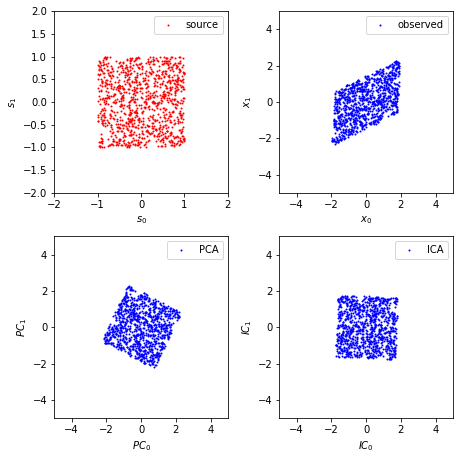

In [17]:
###################### plot
fig, ax=plt.subplots(2, 2, figsize = (6.49, 6.49))
p1,=ax[0,0].plot(S[0,:], S[1,:],'ro',markersize=1)
ax[0,0].legend(p1,labels=['source'])
ax[0,0].set_xlabel('$s_{0}$', fontsize = 10)  
ax[0,0].set_ylabel('$s_{1}$', fontsize = 10)
ax[0,0].set_xlim(-2,2)
ax[0,0].set_ylim(-2,2)
ax[0,0].tick_params(axis='x', which = 'major', labelsize=10)
ax[0,0].tick_params(axis='y', which = 'major', labelsize=10)

p1, = ax[0,1].plot(X[0,:], X[1,:], 'bo', markersize=1)
ax[0,1].legend(p1,labels=['observed'])
ax[0,1].set_xlabel('$x_{0}$', fontsize =10)  
ax[0,1].set_ylabel('$x_{1}$', fontsize=10)
ax[0,1].set_xlim(-5,5)
ax[0,1].set_ylim(-5,5)
ax[0,1].tick_params(axis='x', which = 'major', labelsize=10)
ax[0,1].tick_params(axis='y', which = 'major', labelsize=10)

p1, = ax[1,0].plot(PC[0,:], PC[1,:], 'bo', markersize=1)
ax[1,0].legend(p1,labels=['PCA'])
ax[1,0].set_xlabel('$PC_{0}$',fontsize=10)  
ax[1,0].set_ylabel('$PC_{1}$',fontsize=10)
ax[1,0].set_xlim(-5,5)
ax[1,0].set_ylim(-5,5)
ax[1,0].tick_params(axis='x', which = 'major', labelsize=10)
ax[1,0].tick_params(axis='y', which = 'major', labelsize=10)

p1, = ax[1,1].plot(Y[0,:], Y[1,:], 'bo', markersize=1)
ax[1,1].legend(p1,labels=['ICA'])
ax[1,1].set_xlabel('$IC_{0}$',fontsize=10)  
ax[1,1].set_ylabel('$IC_{1}$',fontsize=10)
ax[1,1].set_xlim(-5,5)
ax[1,1].set_ylim(-5,5)
ax[1,1].tick_params(axis='x', which = 'major', labelsize=10)
ax[1,1].tick_params(axis='y', which = 'major', labelsize=10)
fig.tight_layout()

plt.savefig('ICA_vs_PCA.pdf', dpi=300 )